<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW9/HW9_JBoecher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Imports and Set-Up

In [77]:
# import packages
import io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers 
from keras.layers import Dense, Input, Flatten,\
                   Reshape, LeakyReLU as LR,\
                   Activation, Dropout
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [5]:
# set path
%cd /content/gdrive/MyDrive/ColabNotebooks/

/content/gdrive/MyDrive/ColabNotebooks


In [7]:
# import dataframe from google drive
from google.colab import files 
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['data_all.csv']))

Saving data_all.csv to data_all (4).csv


In [8]:
df.shape

(47088, 100)

In [9]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.7110,3.540000e-01,-0.81500,0.092000,5.820000e-01,-0.730000,-3.380000e-01,0.87900,9.940000e-02,-4.530000e-01,...,-0.1180,-0.46500,4.470000e-02,0.07810,-0.00757,-5.760000e-03,0.000522,1.870000e-04,-1.500000e-05,-2.650000e-06
1,-0.5760,3.410000e-73,0.00243,0.000058,3.090000e-32,-0.000254,-4.810000e-10,0.00859,3.510000e-145,6.830000e-13,...,0.0012,-0.00851,5.320000e-58,-0.00365,-0.01500,-6.600000e-39,-0.032500,1.090000e-93,0.000000e+00,0.000000e+00
2,-0.7040,-3.780000e-02,0.87100,-0.123000,3.480000e-01,-0.858000,3.950000e-02,0.33600,-4.870000e-02,2.620000e-01,...,0.5800,0.17500,-7.880000e-02,0.01860,-0.56000,6.280000e-01,-0.601000,4.270000e-01,-7.080000e-02,7.170000e-04
3,-0.0701,4.190000e-02,0.94500,0.285000,9.810000e-02,-1.210000,7.370000e-02,0.32200,7.970000e-04,-7.150000e-02,...,0.0799,0.02700,2.540000e-03,-0.15100,-0.38300,2.330000e-02,-0.574000,-4.110000e-03,4.690000e-10,3.940000e-20
4,0.3650,3.570000e-02,1.21000,0.868000,1.060000e-01,-1.380000,1.810000e-01,0.31500,3.890000e-04,-4.190000e-01,...,-0.3790,0.21700,1.380000e-03,-0.64200,-0.51500,2.550000e-02,-0.618000,-6.050000e-04,2.820000e-10,8.260000e-22


In [10]:
print(f"My dataframe has {df.shape[0]} rows ({df.shape[0]/6} objects and 6 passbands) and {df.shape[1]} columns (time points/mjd).")

My dataframe has 47088 rows (7848.0 objects and 6 passbands) and 100 columns (time points/mjd).


# 2. Build Autoencoder

The goal of the autoencoder is to reproduce the time series that are provided by the plasticc challenge dataset. The neural network learns parameters that optimize recovering of the original time series from a smaller dimenional middle layer (bottleneck). The parameters are learnt uring training and then implemented during the validation (prediction) phase.

In [11]:
# split data into training and validation sets
x_train, x_test = train_test_split(df, test_size=0.25, shuffle = True)

In [12]:
x_train.shape

(35316, 100)

In [13]:
x_test.shape

(11772, 100)

In [14]:
# add callback
# callback prevents overfitting. Interrupts iterations over the data when model stops improving, rather than running all specified epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)

The architecture chosen below is symmetric. The input layer consists of 100 nodes because the input it 100. At the end, the model expands back to 100 nodes. For the layers in between, I have tried to stick with numbers that can be expressed 2 to the power of n to increase computational power. The bottleneck layer contains the smallest number of nodes. Here, the features are most compressed.

In [15]:
#create model
model = Sequential()
 
#create the model architecture by adding model layers
input_layer = model.add(Dense(100, activation='tanh', input_shape=(100,)))
pre_layer_1 = model.add(Dense(84, activation='tanh'))
pre_layer_2 = model.add(Dense(64, activation='tanh'))
bottle_neck = model.add(Dense(32, activation='tanh', name ="bottle_neck"))
post_layer_1 = model.add(Dense(64, activation='tanh'))
post_layer_2 = model.add(Dense(84, activation='tanh'))
output_layer = model.add(Dense(100, activation='tanh'))

The optimization scheme needs to be defined by the user. Adam is a type of gradient descent used for optimization of the parameters. Mean squared error is an appropriate loss function for regression data.

In [16]:
# optimize
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 84)                8484      
                                                                 
 dense_2 (Dense)             (None, 64)                5440      
                                                                 
 bottle_neck (Dense)         (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 84)                5460      
                                                                 
 dense_5 (Dense)             (None, 100)               8

Fit the model

In [18]:
#need to learn what to look for - always plot the loss function!
model2 = model.fit(x_train, x_train, validation_data=(x_test, x_test),
                     epochs=40, batch_size=100, verbose = 1, callbacks=[callback])
#note that the model allows to give a validation test, 
#this is for a 3fold cross valiation: train-validate-test 
#predict
test_y_predictions = model.predict(x_test)

Epoch 1/40
354/354 [==============================] - 3s 6ms/step - loss: 0.1666 - val_loss: 0.1448
Epoch 2/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1400 - val_loss: 0.1385
Epoch 3/40
354/354 [==============================] - 2s 4ms/step - loss: 0.1359 - val_loss: 0.1364
Epoch 4/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1340 - val_loss: 0.1349
Epoch 5/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1329 - val_loss: 0.1342
Epoch 6/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1322 - val_loss: 0.1338
Epoch 7/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1318 - val_loss: 0.1335
Epoch 8/40
354/354 [==============================] - 2s 4ms/step - loss: 0.1314 - val_loss: 0.1332
Epoch 9/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1310 - val_loss: 0.1328
Epoch 10/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1308 - val_loss: 0.1326

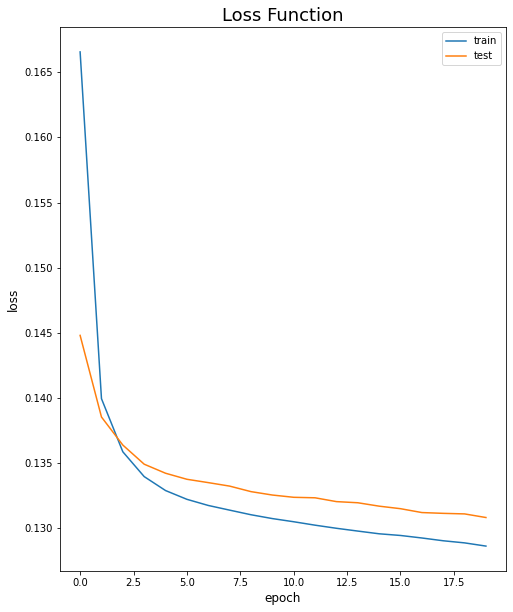

In [19]:
plt.figure(figsize=(8,10))
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Loss Function', size = 18)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Fig. 1. Loss Function.** The loss function is expected to quickly decline at the beginning and to flatten after a certain point. In this model, the loss function in both training and test set exhibit this pattern. Expectedly, the training loss function starts off at a higher loss value and declines more rapidly within the first two iterations.  The loss functions converge at epoch 2. After this point, the training loss function declines at an overall lower level than the test loss function.

In [20]:
ts2plot = 12

In [21]:
obj = int(round((35316 + ts2plot)/6,1))
band = ((35316 + ts2plot)%6) + 1

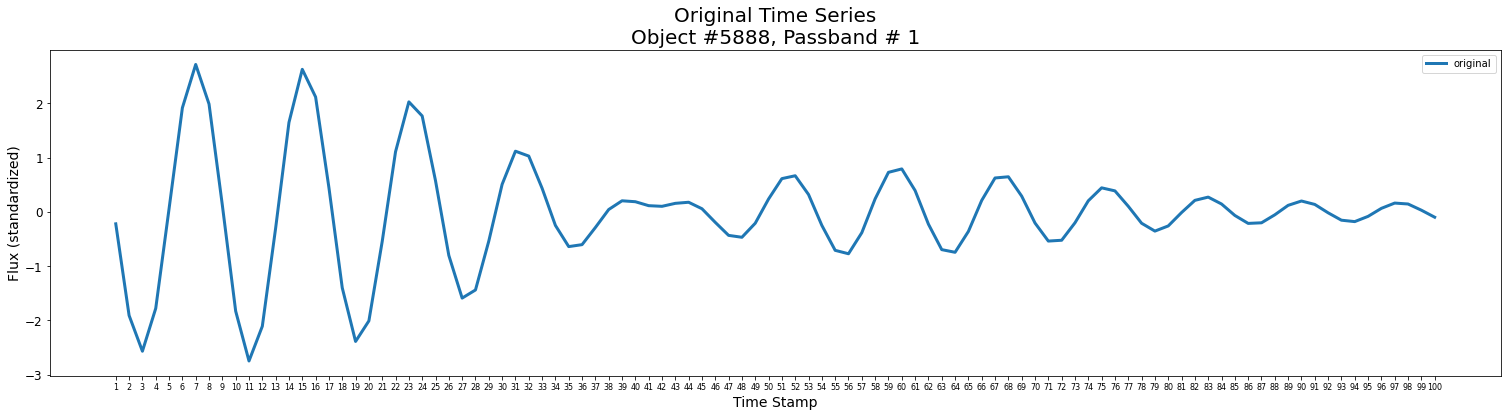

In [22]:
plt.figure(figsize=(26,6))
plt.plot(x_test.iloc[ts2plot], label = "original", linewidth = 3);
plt.xticks(size = 8)
plt.yticks(size = 12)
plt.xlabel("Time Stamp", size = 14)
plt.ylabel("Flux (standardized)", size = 14)
plt.title(f"Original Time Series\nObject #{obj}, Passband # {band}", size = 20)
plt.legend();

**Fig. 2. Original Time Series.** This plot shows the standardized flux values (connected) from object #5888, passband #1 (purple) of the original dataset. The data used here have been observed.  The curve exhibits a sinusoidal shape with smooth troughs at time stamps 34, 61, and 92 and peaks at time stamps 48 and 76. 

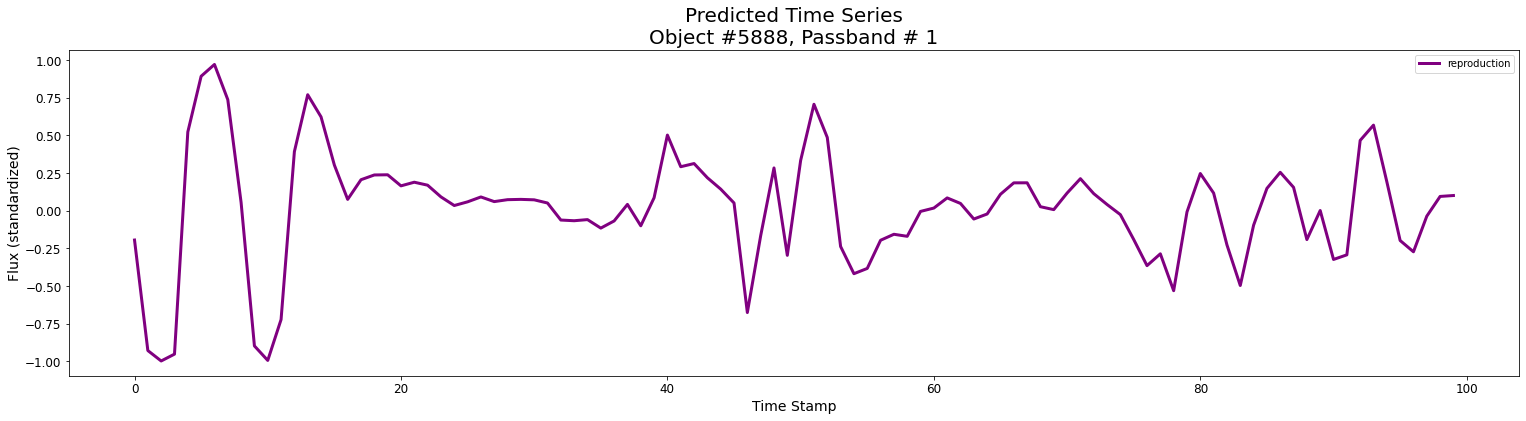

In [23]:
plt.figure(figsize=(26,6))
plt.plot(test_y_predictions[ts2plot], label = "reproduction", color = "purple", linewidth = 3)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel("Time Stamp", size = 14)
plt.ylabel("Flux (standardized)", size = 14)
plt.title(f"Predicted Time Series\nObject #{obj}, Passband # {band}", size = 20)
plt.legend();

**Fig. 3. Predicted Time Series.** This plot shows the predicted flux values (connected) for object #5888, passband #1 (purple). The data used here have been predicted/reconstructed from the bottleneck layer. The curve exhibits a similar overall shape with sinusoidal characteristics. The troughs and peaks are less smooth, but occur at roughly the same time stamps. The reproduced time series is clearly recognizable.

# 3. Extract Features 
A. Extract Features from Bottleneck

In [24]:
bottleneck_output = model.get_layer('bottle_neck').output
model_bottleneck = Model(inputs = model.input, outputs = bottleneck_output)

bottleneck_predictions = model_bottleneck.predict(df)

In [25]:
bottleneck_predictions.shape

(47088, 32)

In [26]:
print(f"The shape of the bottleneck feature array is {bottleneck_predictions.shape}. This corresponds to {bottleneck_predictions.shape[0]} 7848 objects with 6 passbands each (all time series) and 32 bottleneck nodes.")

The shape of the bottleneck feature array is (47088, 32). This corresponds to 47088 7848 objects with 6 passbands each (all time series) and 32 bottleneck nodes.


In [27]:
bottleneck_predictions[0]

array([-2.32962873e-02, -4.86613959e-02, -1.56100085e-02,  7.29403272e-02,
       -4.54774573e-02, -5.75051308e-02,  3.62678133e-02,  8.46893713e-02,
       -1.10080935e-01, -4.33105684e-04,  2.95895580e-02,  1.56036047e-02,
        9.43627134e-02, -5.37655433e-05, -2.04952285e-01,  1.12244010e-01,
       -9.17481929e-02,  1.47761926e-01,  1.63596377e-01, -3.58859152e-02,
        2.91218311e-02, -1.11281471e-02,  3.07734963e-02, -6.02139495e-02,
        6.04626862e-03,  4.16812934e-02, -1.47624814e-03, -2.85773221e-02,
        2.57056020e-02,  6.39334247e-02, -1.31434202e-01, -1.23657823e-01],
      dtype=float32)

B. Import Previously Extracted Features

In [28]:
lcvs_features = pd.read_csv("lcvs_features.csv")

In [29]:
lcvs_features

,object_id,passband,mins,maxs,means,means_std,maxs_std,s_std,median_std,decl
0,615.0,0.0,-117.00,125.0,-3.25,-0.00758,0.0273,0.02280,-0.00942,-61.90
1,615.0,1.0,-1100.00,661.0,-386.00,-0.11100,0.1730,0.16300,-0.13900,-27.80
2,615.0,2.0,-682.00,612.0,-134.00,-0.04310,0.1590,0.12400,-0.07880,-6.58
3,615.0,3.0,-531.00,446.0,-121.00,-0.03960,0.1140,0.09100,-0.05070,-45.60
4,615.0,4.0,-422.00,382.0,-56.00,-0.02190,0.0970,0.07920,-0.03480,-63.80
...,...,...,...,...,...,...,...,...,...,...
7843,214000.0,1.0,-4.06,103.0,6.04,-0.00506,0.0213,0.00531,-0.00654,-14.90
7844,214000.0,2.0,-3.71,150.0,11.50,-0.00359,0.0340,0.00825,-0.00651,-62.70
7845,214000.0,3.0,-3.36,134.0,14.90,-0.00267,0.0296,0.00870,-0.00646,-55.70
7846,214000.0,4.0,-7.01,118.0,14.10,-0.00287,0.0253,0.00806,-0.00653,-35.50


C. Combine Bottleneck Features and Previously Extracted Features

In [30]:
# reshape to match the feature dataframe
bottleneck_predictions = bottleneck_predictions.reshape(7848, bottleneck_predictions.shape[1] * 6)

In [31]:
# convert to dataframe to match feature dataframe
bottleneck_predictions = pd.DataFrame(bottleneck_predictions)

In [32]:
bottleneck_predictions.shape

(7848, 192)

In [33]:
#combine
features = pd.concat([lcvs_features, bottleneck_predictions], axis = 1)

In [34]:
features

,object_id,passband,mins,maxs,means,means_std,maxs_std,s_std,median_std,decl,...,182,183,184,185,186,187,188,189,190,191
0,615.0,0.0,-117.00,125.0,-3.25,-0.00758,0.0273,0.02280,-0.00942,-61.90,...,-0.040837,-0.017377,0.083610,-0.059907,0.015354,0.096085,-0.020603,0.001984,0.036277,-0.000717
1,615.0,1.0,-1100.00,661.0,-386.00,-0.11100,0.1730,0.16300,-0.13900,-27.80,...,-0.036405,-0.007535,-0.017518,0.196286,0.151140,0.018135,-0.053434,0.148447,-0.144402,0.045652
2,615.0,2.0,-682.00,612.0,-134.00,-0.04310,0.1590,0.12400,-0.07880,-6.58,...,0.036996,0.082932,0.071633,0.010525,0.022713,-0.074560,0.042405,0.102774,-0.026638,0.014130
3,615.0,3.0,-531.00,446.0,-121.00,-0.03960,0.1140,0.09100,-0.05070,-45.60,...,0.333282,0.166889,-0.132357,-0.118560,-0.022428,0.060652,0.155414,0.081157,0.063896,0.217999
4,615.0,4.0,-422.00,382.0,-56.00,-0.02190,0.0970,0.07920,-0.03480,-63.80,...,0.094829,0.092890,-0.013877,-0.128550,0.129906,-0.116467,0.032535,0.169821,-0.152727,-0.206827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,214000.0,1.0,-4.06,103.0,6.04,-0.00506,0.0213,0.00531,-0.00654,-14.90,...,-0.008664,-0.022963,-0.057014,-0.024975,0.075525,-0.024719,-0.092403,0.064652,-0.026554,0.045109
7844,214000.0,2.0,-3.71,150.0,11.50,-0.00359,0.0340,0.00825,-0.00651,-62.70,...,-0.001498,-0.053751,-0.039592,0.067909,0.024867,0.033923,-0.034444,0.101126,0.046161,-0.019870
7845,214000.0,3.0,-3.36,134.0,14.90,-0.00267,0.0296,0.00870,-0.00646,-55.70,...,0.018714,-0.019179,0.008536,-0.022728,0.021104,-0.043743,0.020561,-0.061833,-0.053415,0.000290
7846,214000.0,4.0,-7.01,118.0,14.10,-0.00287,0.0253,0.00806,-0.00653,-35.50,...,0.058918,-0.211215,-0.272268,0.026351,0.107296,-0.078389,-0.166849,-0.185793,-0.020801,-0.250737


In [35]:
features.columns = features.columns.astype(str)

# 4. Random Forest Classification
A. Import targets from metadata

In [36]:
df_meta = pd.read_csv("plasticc_train_metadata.csv.gz")

In [37]:
df_obj = pd.concat([df_meta["object_id"], df_meta["target"]], axis = 1 )

In [38]:
df_obj.head()

,object_id,target
0,615,92
1,713,88
2,730,42
3,745,90
4,1124,90


In [67]:
len(df_obj.target.unique())

14

B. Classify

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
#? RandomForestClassifier

In [41]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(features, df_obj.target.values, test_size=0.2)

In [43]:
clf.fit(x_test, y_test)

RandomForestClassifier(max_depth=2, random_state=0)

In [44]:
print(clf.predict(features))

[90 90 90 ... 90 90 90]


In [47]:
train_score = clf.score(x_train, y_train)

In [48]:
print(f"During training, random forest scores {round(train_score,2)} accuracy in assigning time series to the correct target category.")

During training, random forest scores 0.29 accuracy in assigning time series to the correct target category.


In [49]:
test_score = clf.score(x_test, y_test)

In [50]:
print(f"During test, random forest scores {round(test_score,2)} accuracy in assigning time series to the correct target category.")

During test, random forest scores 0.3 accuracy in assigning time series to the correct target category.


My random forest categorization is not very good. It could probably be increased by changing the autoencoder architecture. I'm also not sure if combining the two sets of features in the way that I did is ideal. The features derived from the bottleneck are not meaningful in the same way that the mean, standard deviation, etc. are. Perhaps these types of features should be implemented separately. I might try to run the classification with only one set of features at a time.

C. Plot Confusion Matrix

In [51]:
y_pred = clf.predict(x_test)

In [117]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

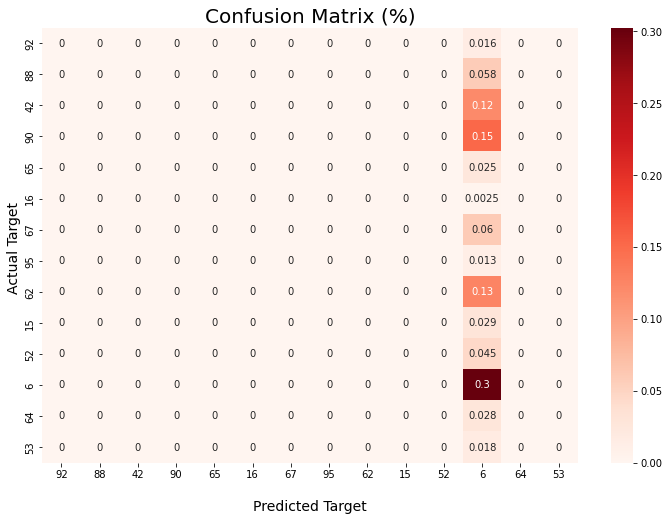

In [83]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Reds')
ax.set_title('Confusion Matrix (%)', size = 20);
ax.set_xlabel('\nPredicted Target', size = 14)
ax.set_xticklabels(df_obj.target.unique())
ax.set_yticklabels(df_obj.target.unique())
ax.set_ylabel('Actual Target ', size = 14);

plt.show()

**Fig. 4. Confusion Matrix.** The confusion matrix reveals how often a certain class has been assigned to a certain class. This allows for better interpretation of the overall performance score. Here, I can see that all my time series have been assigned to the same category. This is clearly bad.

In [101]:
# count occurences of target
unique_target = df_obj.target.unique()
occ = []

for target in unique_target:
    occ.append(df_obj.target[target])

In [114]:
unique_target = unique_target.astype(str)

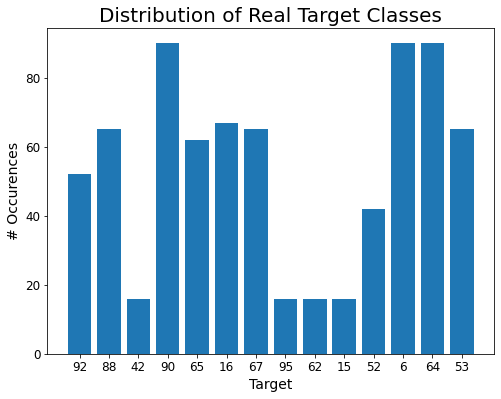

In [116]:
#df_obj.target[92]
plt.figure(figsize=(8,6))
plt.bar(unique_target, occ);
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel("Target", size = 14)
plt.ylabel("# Occurences", size = 14)
plt.title(f"Distribution of Real Target Classes", size = 20);

**Fig. 5. Distribution of Real Target Classes.** The bargraph shows the count of time series in each target class. Most time series are part of category 90, 6, and 64. Fewest time series are part of category 42, 95, 62, and 15. The predicted classification does not represent this distribution. At least the class that everything got lumped into is one of the three most commen classes (6).